# Presto card usage
Data from my prestocard.ca account

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet

In [2]:
## Load data
presto = pd.read_csv("presto_trans.csv",
                    converters={'Amount': lambda s: float(s.replace('$', ''))})
presto['Date'] = pd.to_datetime(presto['Date'])

Text(0.5,0,u'Date')

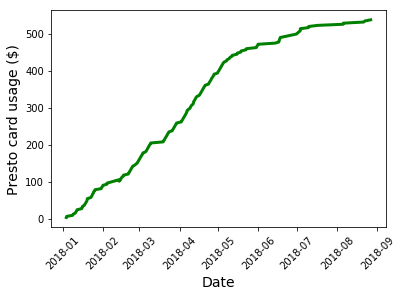

In [3]:
fpp = presto.groupby('Date').sum()[['Amount']]
plt.plot(np.cumsum(fpp), color='g', linewidth=3, label='Actual')
plt.xticks(rotation=45)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)

## Now fit a simple line
Only up to May 8th, the date when I started biking

In [4]:
## Fit a line to data before 2018-05-08
presto_bf = presto.query('Date < "2018-05-08"')
fpp_bf = presto_bf.groupby('Date').sum()[['Amount']]
regr = LinearRegression()
regr.fit(fpp_bf.index.values.reshape(-1,1), np.cumsum(fpp_bf.Amount).values.reshape(-1,1))
rng = pd.date_range('1/1/2018', periods=72, freq='3D')
pred = regr.predict(rng.values.astype(float).reshape(-1,1))

/Users/elder/my-virtualenv/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


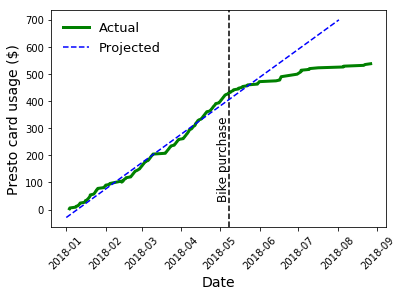

In [5]:
## Plot data
fpp = presto.groupby('Date').sum()[['Amount']]
plt.plot(np.cumsum(fpp), color='g', linewidth=3, label='Actual')
plt.xticks(rotation=45)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.axvline('2018-05-08', color='k', linestyle='--')
plt.plot(rng, pred, color='b', linestyle='--', label='Projected')
plt.text('2018-04-29',310,'Bike purchase', rotation=90, fontsize=12)
plt.legend(frameon=False, fontsize=13)
plt.show()

In [6]:
pred[-1] - np.cumsum(fpp.Amount).values[-1]

array([161.78936654])

### Have saved ~$160 so far

## Now using Facebook Prophet

In [7]:
DS = np.cumsum(fpp.Amount).values
Y = fpp.index.values

df = pd.DataFrame(DS, Y).reset_index()
df.columns = ['ds','y']

m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [8]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
265,2018-11-20 18:56:06
266,2018-11-21 18:56:06
267,2018-11-22 18:56:06
268,2018-11-23 18:56:06
269,2018-11-24 18:56:06


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
265,2018-11-20 18:56:06,664.369702,601.209383,722.387321
266,2018-11-21 18:56:06,666.262860,602.015056,724.893542
267,2018-11-22 18:56:06,668.823534,602.647189,732.357076
268,2018-11-23 18:56:06,672.543694,604.660093,733.635995
269,2018-11-24 18:56:06,671.968358,605.149088,734.718986


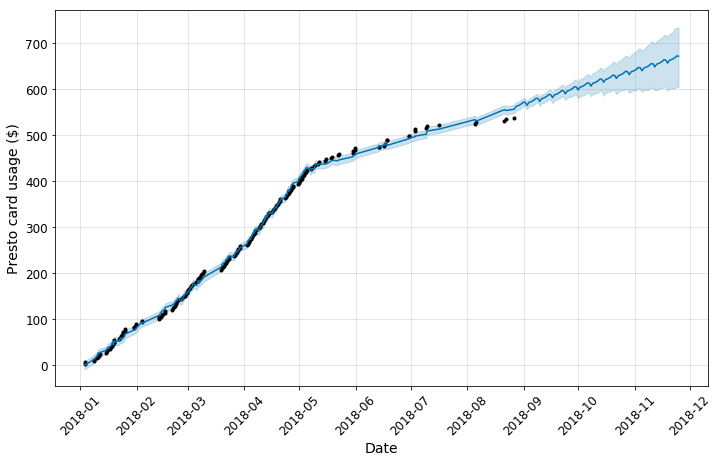

In [10]:
fig1 = m.plot(forecast)
plt.xlabel('Date', fontsize = 14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.show()

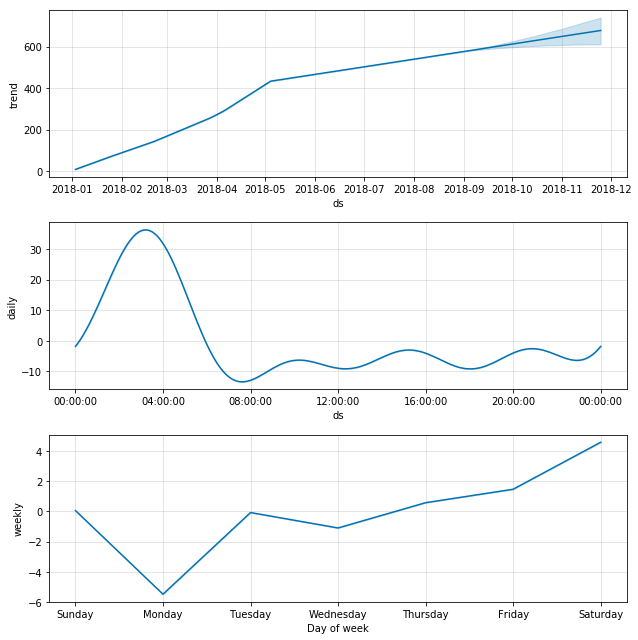

In [11]:
fig2 = m.plot_components(forecast)

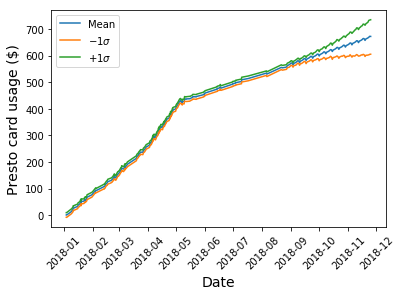

In [12]:
## Plotting using matplotlib

plt.plot(forecast.ds, forecast.yhat, label='Mean')
plt.plot(forecast.ds, forecast.yhat_lower, label='$-1\sigma$')
plt.plot(forecast.ds, forecast.yhat_upper, label='$+1\sigma$')

plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45)

plt.legend()
plt.show()